In [15]:
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from random import random
import numpy as np
import collections
from time import time

In [16]:
### NetworkX functions ###

def nx_template(d, shear):
    # This just makes an nx graph with the right boundary conditions and weighted edges, for use in MWPM
    # Is prepped for changing shear
    G = nx.Graph()
    for row in range(d-1):
        for col in range(d):
            G.add_edge((row, col), (row, (col+1)%d), weight=1)
            G.add_edge((row, col), ((row+1)%d, col), weight=1)
    row = d-1
    for col in range(d):
        G.add_edge((row, col), (row, (col+1)%d), weight=1)
        G.add_edge((row, col), ((row+1)%d, (col+shear)%d), weight=1)
    assert len(G.edges) == 2*(d**2)
    return G
def plot(G):
    positions = {g: (g[1], -g[0]) for g in G.nodes}
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos=positions, node_size=30, node_color='black', edge_color='orange', with_labels=True)
    plt.show()
def display_matches_only(matches):
    G = nx.Graph()
    G.add_edges_from(matches)
    positions = {g: (g[1], -g[0]) for g in G.nodes}
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos=positions, node_size=10, node_color='black', edge_color='orange', with_labels=True)
    plt.show()

In [17]:
### Pauli class for operators and their methods ###

class Pauli:
    def __init__(self, phase, op):
        self.phase = phase
        self.op = op
    def __str__(self):
        return str(("Pauli", self.phase, self.op))
    __repr__ = __str__
    def __mul__(self, other):
        opa = self.op
        opb = other.op
        opc = ''
        n = len(opa)
        assert len(opa) == len(opb)
        phase = self.phase*other.phase
        for i in range(n):
            if opa[i] == 'I':
                opc += opb[i]
            elif opb[i] == 'I':
                opc += opa[i]
            elif opa[i] == opb[i]:
                opc += 'I'
                if opa[i] == 'Y':
                    phase *= -1
            elif (opa[i] == 'X' and opb[i] == 'Z'):
                opc += 'Y'
            elif (opa[i] == 'Z' and opb[i] == 'X'):
                opc += 'Y'
                phase *= -1
            elif (opa[i] == 'X' and opb[i] == 'Y'):
                opc += 'Z'
            elif (opa[i] == 'Y' and opb[i] == 'X'):
                opc += 'Z'
                phase *= -1    
            elif (opa[i] == 'Y' and opb[i] == 'Z'):
                opc += 'X'
            elif (opa[i] == 'Z' and opb[i] == 'Y'):
                opc += 'X'
                phase *= -1 
            else:
                assert 0
        return Pauli(phase, opc)
    def __neg__(self):
        return Pauli(-self.phase, self.op)
    def __eq__(self, other):
        return self.op == other.op and self.phase == other.phase
    def __ne__(self, other):
        return self.op != other.op or self.phase != other.phase
    def __hash__(self):
        return hash(str(self))
    def commutes(self, other):
        return self.__mul__(other) == other.__mul__(self)

In [18]:
### Lattice class for a lattice object with qubits and checks (in dictionary formats) ###
### Initiate Lattice, apply error or specific operator, and correct ###
### At any point, display with dump() method which prints out the lattice as an array ###

class Lattice:
    def __init__(self, d, shear):
        self.d = d
        self.shear = shear
        self.n = 2*(d**2)
        Qubits = collections.OrderedDict() #N.B. qubits are ordered h, v for each check (not line by line)
        for row in range(d):
            for col in range(d):
                address = (row, col, 'h')
                Qubits[address] = 0
                address = (row, col, 'v')
                Qubits[address] = 0
        self.q = Qubits
        Checks = collections.OrderedDict()
        for row in range(self.d):
            for col in range(self.d):
                Checks[row, col] = 0
        self.c = Checks
    def __str__(self):
        return str(("Qubit lattice", self.d, self.n))
    __repr__ = __str__
    def light_checks(self):
        # NB need to change this function when changing shear!
        if self.shear == 0:
            for row in range(self.d):
                for col in range(self.d):
                    val = (self.q[(row, col, 'h')] + self.q[(row, col, 'v')] +  self.q[(row, (col-1)%self.d, 'h')] + self.q[((row-1)%self.d, col, 'v')] ) %2
                    if val:
                        self.c[row, col] = 1
                    else:
                        self.c[row, col] = 0
        else:
            assert 0
    def apply_error(self, threshold):
        errop = ''
        for qubit in list(self.q.keys()):
            if random() < threshold:
                self.q[qubit] = (self.q[qubit]+1)%2
                errop += 'X'
            else:
                errop += 'I'
        self.error = Pauli(1, errop)
        self.light_checks()
    def apply_op(self, Pauli):
        assert len(self.q) == len(Pauli.op)
        for i, qubit in enumerate(list(self.q.keys())):
            if Pauli.op[i] == 'X':
                self.q[qubit] = (self.q[qubit]+1)%2
        self.light_checks()
    def apply_op_z(self, Pauli):
        assert len(self.q) == len(Pauli.op)
        for i, qubit in enumerate(list(self.q.keys())):
            if Pauli.op[i] == 'Z':
                self.q[qubit] = 'Z'
    def dump(self):
        d = self.d*2
        A = np.empty((d, d), dtype=object)
        index = 0
        for i in range(0, d, 2):
            for j in range(0, d, 2):
                ### checks ###
                index += 1
                if list(self.c.values())[index-1] == 1:
                    A[i,j]='*'
                elif list(self.c.values())[index-1] == 0:
                    A[i,j]='+'
                else:
                    assert 0
        horiz = []
        verts = []
        for n, qubit in enumerate(list(self.q.values())):
            if n%2 == 0:
                horiz.append(qubit)
            elif n%2 == 1:
                verts.append(qubit)
            else:
                assert 0
        index = 0
        for i in range(0, d, 2):
            for j in range(1, d, 2):
                ### horiz qubits ###
                index += 1
                if horiz[index-1] == 1:
                    A[i,j]='X'
                elif horiz[index-1] == 0:
                    A[i,j]="-"
                elif horiz[index-1] == 'Z':
                    A[i,j]="Z"
                else:
                    assert 0
        index = 0
        for i in range(1, d, 2):
            for j in range(0, d, 2):
                ### vert qubits ###
                index += 1
                if verts[index-1] == 1:
                    A[i,j]='X'
                elif verts[index-1] == 0:
                    A[i,j]="|"
                elif verts[index-1] == 'Z':
                    A[i, j]="Z"
                else:
                    assert 0
        for i in range(1, d, 2):
            for j in range(1, d, 2):
                A[i,j]=' '
        A = str(A)
        A = A.replace("'", " ")
        print(A)
    def show_op(self, Pauli):
        # shows what the operator would look like if enacted on a fresh lattice (all qubits = 0)
        A = Lattice(self.d, self.shear)
        if 'Z' in Pauli.op:
            A.apply_op_z(Pauli)
        else:
            A.apply_op(Pauli)
        return A.dump()
    def correct(self):
        lit_checks = []
        for key, value in self.c.items():
            if value == 1:
                lit_checks.append(key)
        self.lit_checks = lit_checks
        different_pairs = list(itertools.combinations(lit_checks, 2))
        T = nx_template(self.d, self.shear)
        self.T = T
        M = nx.Graph()
        self.M = M
        for pair in different_pairs:
            path = nx.shortest_path(self.T, pair[0], pair[1], weight='weight')
            distance = -(len(path)-1)
            M.add_edge(pair[0], pair[1], weight=distance)
        matches = nx.max_weight_matching(self.M, True)
        self.matches = matches
        qubit_addresses, paths = get_correction(self.matches, self.T, self.d)
        self.q_a = qubit_addresses
        self.paths = paths
        for address in qubit_addresses:
            self.q[address] = (self.q[address]+1)%2
        self.light_checks()
        corrop = ''
        for i, qubit in enumerate(list(self.q.keys())):
            if qubit in qubit_addresses:
                corrop += 'X'
            else:
                corrop += 'I'
        self.correction = Pauli(1, corrop)
        self.BA = self.correction*self.error
    def win_or_lose(self, verbose=False):
        hop = ''
        vop = ''
        horiz=[(2*n)+1 for n in range(self.d)]
        self.horiz = horiz
        vert=[(self.d*2*n) for n in range(self.d)]
        self.vert = vert
        for i in range(self.n):
            if i in horiz:
                hop += 'Z'
            else:
                hop += 'I'
            if i in vert:
                vop += 'Z'
            else:
                vop += 'I'
        self.H = Pauli(1, hop)
        self.V = Pauli(1, vop)
        cond1 = self.BA.commutes(self.H)
        cond2 = self.BA.commutes(self.V)
        if cond1 and cond2:
            if not verbose:
                return True
            else:
                print("win!")
                print("BA commutes with horizontal operator:", cond1)
                print("BA commutes with vertical operator:", cond2)
        else:
            if not verbose:
                return False
            else:
                print("lose")
                print("BA commutes with horizontal operator:", cond1)
                print("BA commutes with vertical operator:", cond2)

In [19]:
### This function works with the matches to return a list of qubit addresses to flip ###

def get_correction(matches, template, d):
    paths = []
    for pair in list(matches):
        paths.append(nx.shortest_path(template, pair[0], pair[1], weight='weight'))
    qubit_list = []
    for path in paths:
        z = len(path)
        for r in range(z-1):
            qubit_list.append([path[r], path[r+1]])
    qubit_addresses = []
    for pair in qubit_list:
        rows_eq = pair[0][0] == pair[1][0]
        cols_eq = pair[0][1] == pair[1][1]
        if rows_eq:
            assert not cols_eq
            if abs(pair[0][1]-pair[1][1]) == d-1:
                if pair[0][1] < pair[1][1]:
                    qubit_addresses.append((pair[1][0], pair[1][1], 'h'))
                elif pair[0][1] > pair[1][1]:
                    qubit_addresses.append((pair[0][0], pair[0][1], 'h'))
            else:
                if pair[0][1] < pair[1][1]:
                    qubit_addresses.append((pair[0][0], pair[0][1], 'h'))
                elif pair[0][1] > pair[1][1]:
                    qubit_addresses.append((pair[1][0], pair[1][1], 'h'))
        if cols_eq:
            assert not rows_eq
            if abs(pair[0][0]-pair[1][0]) == d-1:
                if pair[0][0] < pair[1][0]:
                    qubit_addresses.append((pair[1][0], pair[1][1], 'v'))
                elif pair[0][0] > pair[1][0]:
                    qubit_addresses.append((pair[0][0], pair[0][1], 'v'))
            else:
                if pair[0][0] < pair[1][0]:
                    qubit_addresses.append((pair[0][0], pair[0][1], 'v'))
                elif pair[0][0] > pair[1][0]:
                    qubit_addresses.append((pair[1][0], pair[1][1], 'v'))
    return qubit_addresses, paths

In [20]:
def run(d, shear, threshold):
    A = Lattice(d, shear)
    A.apply_error(threshold)
    A.correct()
    result = A.win_or_lose()
    A.dump()
    return result

In [24]:
def repeat(d, shear, threshold, reps):
    results = []
    for rep in range(reps):
        A = Lattice(d, shear)
        A.apply_error(threshold)
        A.correct()
        results.append(A.win_or_lose())
    return results.count(False)/reps

In [25]:
def graph(d_range, shear, threshold_range, reps, title):
    t0=time()
    for d in d_range:
        y = []
        for thresh in threshold_range:
            y.append(repeat(d, shear, thresh, reps))
        plt.plot(threshold_range, y, label = d, linewidth=2)
    t1=time()
    print("time taken = ", t1-t0)
    plt.legend(title="distance", loc=1, fontsize='small', fancybox=True)
    plt.ylabel('probability of decoder failure')
    plt.xlabel('probability of error per qubit')
    plt.suptitle(title)
    plt.show()

In [26]:
def as_should(d_range, shear, threshold_range, reps, title):
    for thresh in threshold_range:
        y = []
        for d in d_range:
            y.append(repeat(d, shear, thresh, reps))
        plt.plot(d, y, label = thresh, linewidth=2)
    plt.legend(title="threshold", loc=1, fontsize='small', fancybox=True)
    plt.ylabel('probability of decoder failure')
    plt.xlabel('Lattice size')
    plt.suptitle(title)
    plt.show()

In [10]:
six = Lattice(8, 0)
six.apply_error(0.1)
six.dump()

[[ +   -   +   -   +   -   +   -   +   -   *   X   *   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   *   X   *   -   *   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       X       |       |       |       |     ]
 [ +   -   +   -   +   -   *   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   *   -   +   -   +   -   +   -   +   -   *   -   +   - ]
 [ |       X       |       |       |       |       X       |     ]
 [ +   -   *   -   *   -   +   -   *   X   *   -   *   -   +   - ]
 [ |       |       X       |       |       |       |       |     ]
 [ +   -   *   X   +   -   +   -   *   X   *   -   +   -   *   - ]
 [ |       |       |       |       |       |       |       X     ]
 [ +   -   *   -   +   -   *   -   +   -   +   -   +   -   *   - ]
 [ |       X       |       X       |       |       |       |     ]
 [ +   -   *   -   +   -   *   -   +   -   +   -   +   -   +  

In [11]:
six.correct()
six.win_or_lose()

True

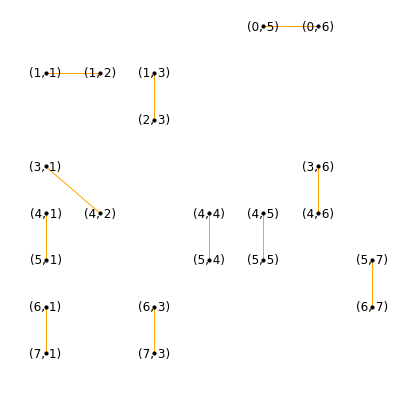

In [12]:
display_matches_only(six.matches)

In [13]:
six.show_op(six.correction)

[[ +   -   +   -   +   -   +   -   +   -   *   X   *   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   *   X   *   -   *   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       X       |       |       |       |     ]
 [ +   -   +   -   +   -   *   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   *   X   +   -   +   -   +   -   +   -   *   -   +   - ]
 [ |       |       X       |       |       |       X       |     ]
 [ +   -   *   -   *   -   +   -   *   -   *   -   *   -   +   - ]
 [ |       X       |       |       X       X       |       |     ]
 [ +   -   *   -   +   -   +   -   *   -   *   -   +   -   *   - ]
 [ |       |       |       |       |       |       |       X     ]
 [ +   -   *   -   +   -   *   -   +   -   +   -   +   -   *   - ]
 [ |       X       |       X       |       |       |       |     ]
 [ +   -   *   -   +   -   *   -   +   -   +   -   +   -   +  

In [14]:
six.dump()

[[ +   -   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   +   X   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       X       X       |       |       |       |       |     ]
 [ +   -   +   -   +   -   +   -   +   X   +   -   +   -   +   - ]
 [ |       X       X       |       X       X       |       |     ]
 [ +   -   +   X   +   -   +   -   +   X   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   +   -   +   -   +   -   +   -   +   -   +   -   +  

In [16]:
six.show_op(six.V)

[[ +   Z   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   Z   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   Z   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   Z   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   Z   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   Z   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   Z   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   Z   +   -   +   -   +   -   +   -   +   -   +   -   +  

In [17]:
six.show_op(six.H)

[[ +   -   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ Z       Z       Z       Z       Z       Z       Z       Z     ]
 [ +   -   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   +   -   +   -   +   -   +   -   +   -   +   -   +   - ]
 [ |       |       |       |       |       |       |       |     ]
 [ +   -   +   -   +   -   +   -   +   -   +   -   +   -   +  

In [18]:
six.V.commutes(six.BA)

True

In [19]:
six.H.commutes(six.BA)

True

In [27]:
threshold_range=list(np.arange(0.035, 0.085, 0.005))

time taken =  0.9099655151367188


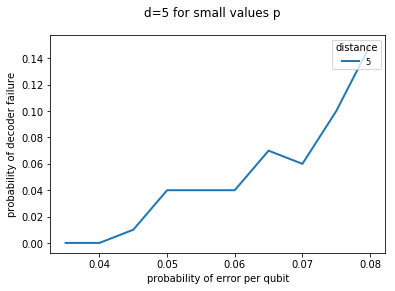

In [28]:
graph([5], 0, threshold_range, 100, 'd=5 for small values p')

For d=5, pthresh=0.08, we have psuccess=0.87, pfail=0.13, which agrees with the article.